# Clasificación de datos posterior al agrupamiento

Utilizar un arbol de decisión para determinar las variables más importantes para el clustering y la precisión del modelo

## Carga de datos

In [1]:
import os
import sys
import pandas as pd
import numpy as np
%pip install -q ipywidgets
import ipywidgets as widgets

directorio = '../Results'
# directorio = '/content'

# Leer archivos xlsx dentro de la carpeta Results de manera recursiva
files = []
for r, d, f in os.walk(directorio):
  for file in f:
    if '.xlsx' in file:
      files.append(os.path.join(r, file))


# Seleccionar archivo a leer
dropdown = widgets.Dropdown(
  options=[('Seleccionar archivo', None)] + [(f, f) for f in files],
  description='Archivo:',
  disabled=False,
)
nombre_archivo = '';
def on_change(change):
  if change['type'] == 'change' and change['name'] == 'value':
    if change['new'] is not None:
      global nombre_archivo
      global X
      global y1
      global y2
      nombre_archivo = change['new']
      print('Archivo seleccionado:', nombre_archivo)
      ruta = os.path.join(directorio, nombre_archivo)

      # Data split y seleccion de modelos
      dataset = pd.read_excel(ruta)

      X = dataset.drop(columns=['cluster_kmeans', 'cluster_hc', 'Comunidad'])
      y1 = dataset['cluster_kmeans']
      y2 = dataset['cluster_hc']
dropdown.observe(on_change)
display(dropdown)

Note: you may need to restart the kernel to use updated packages.


Dropdown(description='Archivo:', options=(('Seleccionar archivo', None), ('../Results\\00-clusters-original-co…

Archivo seleccionado: ../Results\04-clusters-limpio-con-categoricos\clusters.xlsx


## Modelo

Balance de clases kmeans y jerarquico
cluster_kmeans
2    687
3    196
1    158
Name: count, dtype: int64
cluster_hc
3    798
1    142
2    101
Name: count, dtype: int64


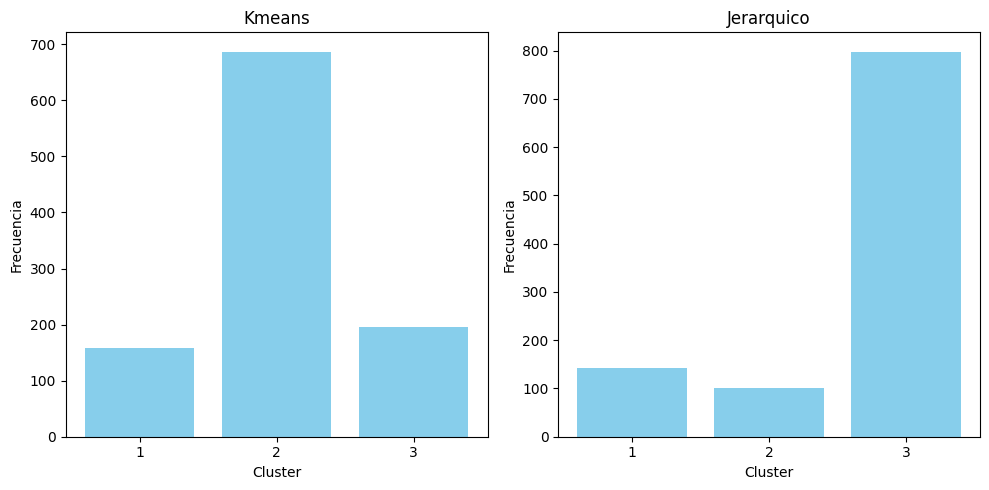

In [2]:
# Ver balance de clases


print('Balance de clases kmeans y jerarquico')
print(y1.value_counts())
print(y2.value_counts())

# histograma de clases

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(y1, bins=range(1, 5), align='left', rwidth=0.8, color='skyblue')
axs[0].set_title('Kmeans')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Frecuencia')
# set x-axis ticks to integer values only
axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axs[1].hist(y2, bins=range(1, 5), align='left', rwidth=0.8, color='skyblue')
axs[1].set_title('Jerarquico')
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Frecuencia')
# set x-axis ticks to integer values only
axs[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

In [3]:
from sklearn.model_selection import train_test_split


# Identificar variables categóricas y numéricas
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

display(numerical_features)
display(categorical_features)

Index(['alumnos', '1p_total_actividades_asignadas',
       '1p_total_actividades_evaluativas',
       '1p_porcentaje_evidencias_calificadas',
       '1p_total_actividades_calificadas', '1p_total_actividades_entregadas',
       '1p_porcentaje_evidencias_calificadas_tiempo',
       '1p_total_actividades_calificadas_tiempo', '1p_porcentaje_aprobados',
       '2p_total_actividades_asignadas', '2p_total_actividades_evaluativas',
       '2p_porcentaje_evidencias_calificadas',
       '2p_total_actividades_calificadas', '2p_total_actividades_entregadas',
       '2p_porcentaje_evidencias_calificadas_tiempo',
       '2p_total_actividades_calificadas_tiempo', '2p_porcentaje_aprobados',
       'total_actividades_calificadas', 'trabajos_por_calificar',
       'correos_enviados', 'correos_recibidos'],
      dtype='object')

Index(['carrera', 'Espacio_Académico'], dtype='object')

Note: you may need to restart the kernel to use updated packages.
Modelo de bosque aleatorio para Kmeans
Mejores hiperparámetros: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Exactitud: 0.9521531100478469
Precisión: 0.9521629719969954
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


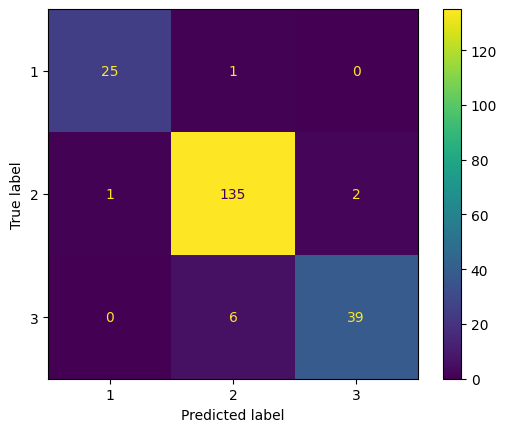

(209,) (209,)
[1 2 3]
              precision    recall  f1-score   support

           1       0.96      0.96      0.96        26
           2       0.95      0.98      0.96       138
           3       0.95      0.87      0.91        45

    accuracy                           0.95       209
   macro avg       0.95      0.94      0.94       209
weighted avg       0.95      0.95      0.95       209



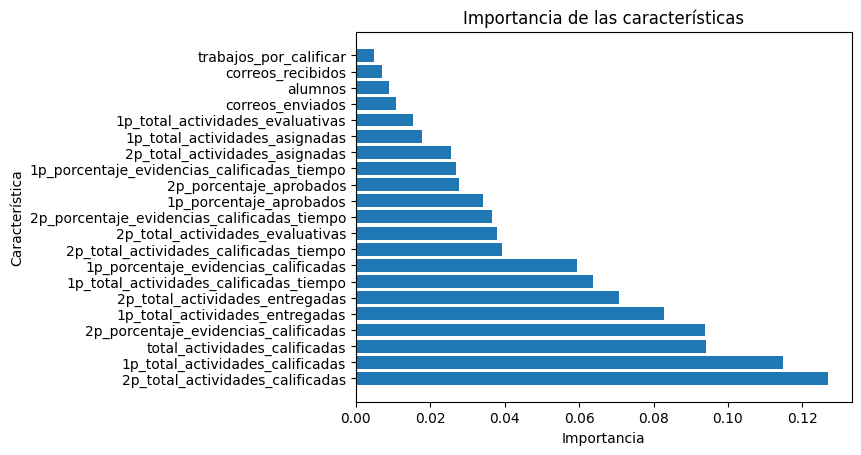

Modelo de bosque aleatorio para Jerarquico
Mejores hiperparámetros: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Exactitud: 0.9760765550239234
Precisión: 0.9757984533526328
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


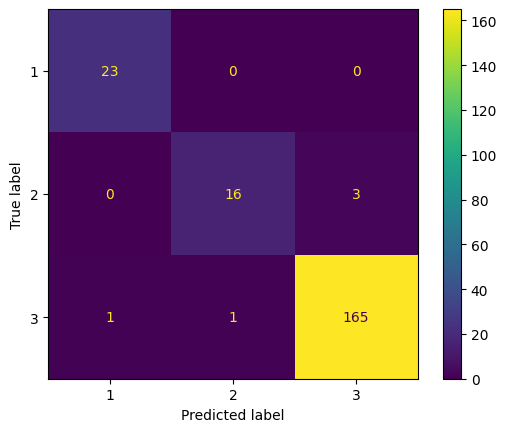

(209,) (209,)
[1 2 3]
              precision    recall  f1-score   support

           1       0.96      1.00      0.98        23
           2       0.94      0.84      0.89        19
           3       0.98      0.99      0.99       167

    accuracy                           0.98       209
   macro avg       0.96      0.94      0.95       209
weighted avg       0.98      0.98      0.98       209



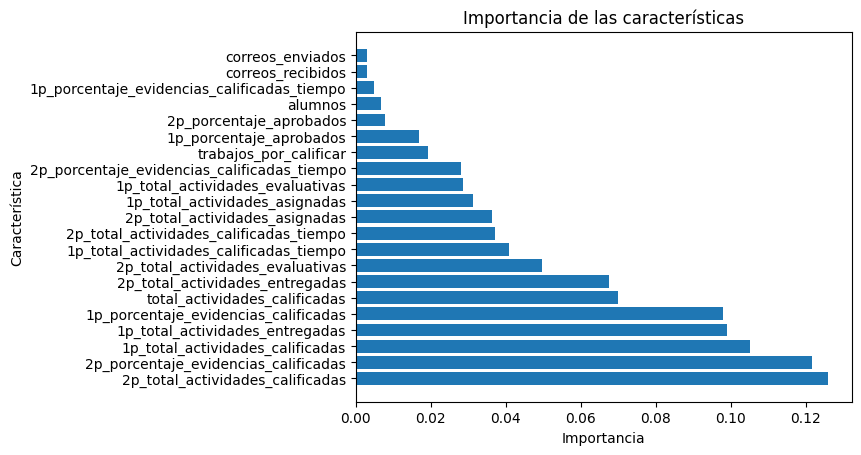

In [9]:
# import plotly.express as px
# usando matplotlib
import matplotlib.pyplot as plt


# variables mas importantes
from sklearn.ensemble import RandomForestClassifier
# grid search para encontrar los mejores hiperparámetros
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
%pip install -q imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

def random_forest(X, y, title = 'Kmeans'):
  print('Modelo de bosque aleatorio para', title)

  
  # Solo usando variables numéricas
  x = X[numerical_features]

  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

  # Crear el modelo de bosque aleatorio
  rf = RandomForestClassifier(random_state=42)

  # Pipelines

  # Crear un transformador solo para las variables categóricas 
  # categorical_transformer = OneHotEncoder()

  # Crear un transformador para todas las variables
  # preprocessor = ColumnTransformer(
  #   transformers=[
  #     ('cat', categorical_transformer, categorical_features)
  #   ], # se evitan or temas de categorias desconocidas en test que no estan en train
  #   remainder='passthrough'
  # )

  # Crear un pipeline con el preprocesador el balanceo de clases y el modelo
  pipeline = Pipeline([
    # ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', rf)
  ])
    
  # Definir la cuadrícula de búsqueda
  param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10]
  }

  # Realizar la búsqueda en la cuadrícula
  grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
  grid_search.fit(X_train, y_train)

  # Obtener los mejores hiperparámetros

  best_params = grid_search.best_params_
  print('Mejores hiperparámetros:', best_params)

  # quitar classifier__ de los mejores hiperparametros
  best_params = {k.replace('classifier__', ''): v for k, v in best_params.items()}
  # Crear un modelo con los mejores hiperparámetros
  rf_best = RandomForestClassifier(random_state=42, **best_params)

  # Entrenar el modelo
  rf_best.fit(X_train, y_train)

  # Predecir los datos de prueba
  y_pred = rf_best.predict(X_test)

  # Calcular la exactitud
  accuracy = accuracy_score(y_test, y_pred)
  print('Exactitud:', accuracy)

  # Calcular la precisión
  precision = precision_score(y_test, y_pred, average='weighted')
  print('Precisión:', precision)
  print(type(y_test), type(y_pred))
  # matriz de confusión
  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_best.classes_)
  disp.plot()
  plt.show()

  print(y_test.shape, y_pred.shape)
  print(rf_best.classes_)
  target_names = [str(cls) for cls in rf_best.classes_]
  report = classification_report(y_test, y_pred, target_names=target_names)
  print(report)


  # Obtener la importancia de las características
  feature_importances = pd.DataFrame({'feature': numerical_features, 'importance': rf_best.feature_importances_})
  feature_importances = feature_importances.sort_values('importance', ascending=False)

  # Graficar las características más importantes
  fig, ax = plt.subplots()
  ax.barh(feature_importances['feature'], feature_importances['importance'])
  ax.set_xlabel('Importancia')
  ax.set_ylabel('Característica')
  ax.set_title('Importancia de las características')
  plt.show()

random_forest(X, y1, 'Kmeans')
random_forest(X, y2, 'Jerarquico')